# 1. 데이터 로드
## 1.1 데이터 로드 및 확인

In [1]:
import datetime
from dateutil import relativedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics 

from util import Utils as ut

train = pd.read_csv('input/funda_train.csv')

train.head()

C:\Users\simamoto\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [2]:
# 데이터 정보 확인
train.info() # 인트형 변수가 3개 존재한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [3]:
# 결착 데이터 확인
train.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

In [4]:
train.isnull().mean() # 결착율이 31% 60% 인 컬럼이 존재한다. (데이터 튜닝이 필요하다)

store_id            0.000000
card_id             0.000000
card_company        0.000000
transacted_date     0.000000
transacted_time     0.000000
installment_term    0.000000
region              0.311558
type_of_business    0.602843
amount              0.000000
dtype: float64

<b>[결착율 높은 데이터 분석]</b><br>
1. 결착율이 높은 데이터는 지역('region') 과 업소형태('type_of_business')이다.
2. 'store_id' 가 같은데 'region' 혹은 'type_of_business' 가 NaN 일 경우 다른 컬럼값을 이용해 채워줄 수 있으므로 조사해본다.

In [5]:
# column_key 로 주어진 컬럼은 'store_id' 와 일치할 경우 동일한 값을 유지해야 한다.
# 일부만 누락되어 있는지 확인하기 위해 조사
def CheckEmptyItem( df, column_key ) :
    
    store_id_cnt = 0
    empty_item_cnt = 0
    for store_id in range(train['store_id'].max()+1) :
        # store_id 개수와 empty_item 개수를 파악해 일치하지 않을 경우를 찾는다.
        store_id_cnt = len( train[train['store_id']==store_id].index )
        empty_item_cnt = train[train['store_id'] == store_id][column_key].isnull().sum()
        
        # store_id 를 보유한 행이 존재하고, empty_item 개수가 0이 아니며 store_id 와 empty_item 개수가 다르다면 일부만 누락된 행이다.
        if 0 != store_id_cnt and 0 != empty_item_cnt and store_id_cnt != empty_item_cnt :
            print( store_id )

In [6]:
# type_of_business는 store_id 에 매칭되지만 유실된 NaN 있을 경우 같은 값을 채워주기 위해 조사
CheckEmptyItem( train, 'type_of_business' )

In [7]:
# type_of_business는 store_id 에 매칭되지만 유실된 NaN 있을 경우 같은 값을 채워주기 위해 조사
CheckEmptyItem( train, 'region' )

<b>[조사 결과]</b><br>
1. 결국 결착된 데이터는 전부 누락된 데이터이기 때문에 임의의 데이터로 채워주거나 drop 을 고려한다.
2. 임의의 데이터로 채운 후 조사해보고, 드압한 후 테스트해 결과를 보고 결정한다.

# 2. 데이터 전처리
## 2.1 정수형 변수 조사 및 리타입

In [8]:
# 미리 제작해둔 유틸을 이용해 DataFrame Column 별 정수형변수의 최대 최소값을 출력한다.
ut.convert_data_type( train, mode='print' )

key: store_id
	min: 0
	max: 2136
key: card_id
	min: 0
	max: 4663856
key: installment_term
	min: 0
	max: 93


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000
5,0,5,c,2016-06-02,13:09,0,NaN,기타 미용업,2000.000000
6,0,6,f,2016-06-02,15:33,0,NaN,기타 미용업,2000.000000
7,0,7,a,2016-06-02,17:18,0,NaN,기타 미용업,7857.142857
8,0,8,c,2016-06-02,18:30,0,NaN,기타 미용업,2000.000000
9,0,9,a,2016-06-02,19:56,0,NaN,기타 미용업,1857.142857


<b>[조사 결과]</b><br>
1. 최대 최소값이 전부 int32 보다 작은 값에 들어가기 때문에 데이터 타입을 변경한다.

In [9]:
train = ut.convert_data_type( train, mode='convert' )
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int16
card_id             int32
card_company        object
transacted_date     object
transacted_time     object
installment_term    int8
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int16(1), int32(1), int8(1), object(5)
memory usage: 343.9+ MB


<b>변경 후 메모리 사용량이 450MB 에서 344MB 로 줄어든 것을 확인할 수 있다.</b>

## 2.2 월별 매출로 전환

In [10]:
# 데이터는 월별 매출이기 때문에 Date 를 월로 변경하고 월별 매출액으로 전환해 새로운 데이터 프레임으로 변경한다.

#우선 시계열 데이터를 하나로 합친다.

train['date'] = train['transacted_date']+' '+train['transacted_time']
train['date'] = pd.to_datetime(train['date'])

train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,date
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00


In [11]:
#transacted_date, transacted_time을 드랍한다.
train = train.drop( 'transacted_date', axis=1 )
train = train.drop( 'transacted_time', axis=1 )

train.head()

,store_id,card_id,card_company,installment_term,region,type_of_business,amount,date
0,0,0,b,0,NaN,기타 미용업,1857.142857,2016-06-01 13:13:00
1,0,1,h,0,NaN,기타 미용업,857.142857,2016-06-01 18:12:00
2,0,2,c,0,NaN,기타 미용업,2000.000000,2016-06-01 18:52:00
3,0,3,a,0,NaN,기타 미용업,7857.142857,2016-06-01 20:22:00
4,0,4,c,0,NaN,기타 미용업,2000.000000,2016-06-02 11:06:00


In [12]:
# 시계열 데이터로 정렬한 후 월별 합으로 resample 한다.
train.set_index( 'date', inplace=True )
train

,store_id,card_id,card_company,installment_term,region,type_of_business,amount
date,,,,,,,
2016-06-01 13:13:00,0,0,b,0,NaN,기타 미용업,1857.142857
2016-06-01 18:12:00,0,1,h,0,NaN,기타 미용업,857.142857
2016-06-01 18:52:00,0,2,c,0,NaN,기타 미용업,2000.000000
2016-06-01 20:22:00,0,3,a,0,NaN,기타 미용업,7857.142857
2016-06-02 11:06:00,0,4,c,0,NaN,기타 미용업,2000.000000
2016-06-02 13:09:00,0,5,c,0,NaN,기타 미용업,2000.000000
2016-06-02 15:33:00,0,6,f,0,NaN,기타 미용업,2000.000000
2016-06-02 17:18:00,0,7,a,0,NaN,기타 미용업,7857.142857
2016-06-02 18:30:00,0,8,c,0,NaN,기타 미용업,2000.000000


In [13]:
train = train.fillna({ 'region' : '기타 도시', 'type_of_business' : '기타 업종' })

train

,store_id,card_id,card_company,installment_term,region,type_of_business,amount
date,,,,,,,
2016-06-01 13:13:00,0,0,b,0,기타 도시,기타 미용업,1857.142857
2016-06-01 18:12:00,0,1,h,0,기타 도시,기타 미용업,857.142857
2016-06-01 18:52:00,0,2,c,0,기타 도시,기타 미용업,2000.000000
2016-06-01 20:22:00,0,3,a,0,기타 도시,기타 미용업,7857.142857
2016-06-02 11:06:00,0,4,c,0,기타 도시,기타 미용업,2000.000000
2016-06-02 13:09:00,0,5,c,0,기타 도시,기타 미용업,2000.000000
2016-06-02 15:33:00,0,6,f,0,기타 도시,기타 미용업,2000.000000
2016-06-02 17:18:00,0,7,a,0,기타 도시,기타 미용업,7857.142857
2016-06-02 18:30:00,0,8,c,0,기타 도시,기타 미용업,2000.000000


In [14]:
df_month = pd.DataFrame()

list_data_mon = []

for store_id in tqdm( train.groupby('store_id') ):# store_id 에 상점별 ID 가 tuple 형태로 enumerate 할 수 있게 된다.
    
    # 상점별(ID) 데이터를 추출한다.
    data_num = train[train.store_id==store_id[0]]
    
    # 월간 내역으로 resample
    resampled = data_num['amount'].resample(rule='m')
    
    # 월단위로 값을 합산한다.
    sum_amount = resampled.sum()
    
    # 월간 거래량을 기록한다.
    sum_deal_count = resampled.count()
    
    # 합산한 데이터를 새로운 DataFrame 에 매핑한다. (series to DataFrame)
    data_mon = pd.concat([sum_amount],axis=1)
    data_mon = pd.concat([data_mon, sum_deal_count], axis=1)

    # store_id, 업종, 지역 정보를 추가한다.
    data_mon.insert(0,'store_id',store_id[0])
    data_mon.insert(1, 'type_of_business', data_num['type_of_business'].unique()[0] )
    data_mon.insert(1, 'region', data_num['region'].unique()[0] )
    
    # 합산한 결과를 list 에 append 한다.
    list_data_mon.append(data_mon)

# dataframe 으로 변환한다.
df_month = pd.concat(list_data_mon)

# 컬럼명 재정의
df_month.columns=['store_id', 'region', 'type_of_business', 'amount', 'deal_count']

# 시계열 데이터를 index 에서 다시 column 으로 변경한다. (추후 시계열 데이터를 이용해 feature 변경을 활용하기 위해서)
df_month.reset_index(inplace=True)

df_month.info()


100%|██████████| 1967/1967 [00:35<00:00, 56.03it/s]


,date,store_id,region,type_of_business,amount,deal_count
0,2016-06-30,0,기타 도시,기타 미용업,7.470000e+05,145
1,2016-07-31,0,기타 도시,기타 미용업,1.005000e+06,178
2,2016-08-31,0,기타 도시,기타 미용업,8.715714e+05,171
3,2016-09-30,0,기타 도시,기타 미용업,8.978571e+05,160
4,2016-10-31,0,기타 도시,기타 미용업,8.354286e+05,167
5,2016-11-30,0,기타 도시,기타 미용업,6.970000e+05,132
6,2016-12-31,0,기타 도시,기타 미용업,7.618571e+05,145
7,2017-01-31,0,기타 도시,기타 미용업,5.856429e+05,118
8,2017-02-28,0,기타 도시,기타 미용업,7.940000e+05,147
9,2017-03-31,0,기타 도시,기타 미용업,7.202571e+05,134


In [15]:
df_month

,date,store_id,region,type_of_business,amount,deal_count
0,2016-06-30,0,기타 도시,기타 미용업,7.470000e+05,145
1,2016-07-31,0,기타 도시,기타 미용업,1.005000e+06,178
2,2016-08-31,0,기타 도시,기타 미용업,8.715714e+05,171
3,2016-09-30,0,기타 도시,기타 미용업,8.978571e+05,160
4,2016-10-31,0,기타 도시,기타 미용업,8.354286e+05,167
5,2016-11-30,0,기타 도시,기타 미용업,6.970000e+05,132
6,2016-12-31,0,기타 도시,기타 미용업,7.618571e+05,145
7,2017-01-31,0,기타 도시,기타 미용업,5.856429e+05,118
8,2017-02-28,0,기타 도시,기타 미용업,7.940000e+05,147
9,2017-03-31,0,기타 도시,기타 미용업,7.202571e+05,134


## 2.3 지역과 업종의 개수 파악 및 최적화
1. 너무 많은 개수일 경우 트레이닝에 방해가 되기 때문에 최적화가 필요하다.

In [16]:
# 유일성을 보장하는 region 개수
len( df_month.region.unique() )

181

In [17]:
# region 181개는 너무 많다고 판단되기 때문에 지역을 '별시 혹은 도단위로 변경한다.
# df_month[['region_1', 'region_2']] = df_month['region'].str.split(' ', n=1, expand=True)

# df_month.drop(['region', 'region_2'], axis='columns', inplace=True)

# df_month.rename(columns={'region_1' : 'region'}, inplace=True)

# df_month

df_month.region = df_month.region.str[:2]
df_month

,date,store_id,region,type_of_business,amount,deal_count
0,2016-06-30,0,기타,기타 미용업,7.470000e+05,145
1,2016-07-31,0,기타,기타 미용업,1.005000e+06,178
2,2016-08-31,0,기타,기타 미용업,8.715714e+05,171
3,2016-09-30,0,기타,기타 미용업,8.978571e+05,160
4,2016-10-31,0,기타,기타 미용업,8.354286e+05,167
5,2016-11-30,0,기타,기타 미용업,6.970000e+05,132
6,2016-12-31,0,기타,기타 미용업,7.618571e+05,145
7,2017-01-31,0,기타,기타 미용업,5.856429e+05,118
8,2017-02-28,0,기타,기타 미용업,7.940000e+05,147
9,2017-03-31,0,기타,기타 미용업,7.202571e+05,134


In [18]:
len( df_month.region.unique() )

18

In [19]:
# 업종도 146개로 지나치게 종류가 많다.
len( df_month.type_of_business.unique() )

146

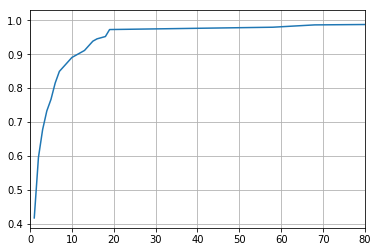

In [20]:
business_store_count = df_month.groupby('type_of_business').store_id.nunique()
business_store_count.value_counts(normalize=True).sort_index().cumsum().plot()
plt.xlim(0, 80)
plt.grid()
plt.show()

In [21]:
# 10개 이하의 스토어를 가지는 business type은 다 '기타 업종'으로
df_month.type_of_business = df_month.type_of_business.astype('object')
df_month.loc[df_month.type_of_business.isin(business_store_count[business_store_count<=10].index), 'type_of_business'] = '업종 누락'
df_month.type_of_business = df_month.type_of_business.astype('category')

df_month

,date,store_id,region,type_of_business,amount,deal_count
0,2016-06-30,0,기타,기타 미용업,7.470000e+05,145
1,2016-07-31,0,기타,기타 미용업,1.005000e+06,178
2,2016-08-31,0,기타,기타 미용업,8.715714e+05,171
3,2016-09-30,0,기타,기타 미용업,8.978571e+05,160
4,2016-10-31,0,기타,기타 미용업,8.354286e+05,167
5,2016-11-30,0,기타,기타 미용업,6.970000e+05,132
6,2016-12-31,0,기타,기타 미용업,7.618571e+05,145
7,2017-01-31,0,기타,기타 미용업,5.856429e+05,118
8,2017-02-28,0,기타,기타 미용업,7.940000e+05,147
9,2017-03-31,0,기타,기타 미용업,7.202571e+05,134


In [22]:
# 16 개 업종으로 변환
len( df_month.type_of_business.unique() )

17

## 2.4 지역 및 업종의 데이터를 숫자값으로 변경한다.

In [23]:
# 지역을 list 로 받아 다시 dictionary 로 변경해준다.
list_region = df_month['region'].unique()
dict_region = { list_region[idx] : idx for idx in range( 0, len(list_region) ) }

print( dict_region )

# row를 순회하며 일치하는 값을 숫자로 변경하는 함수
def change_region(row) :
    if row['region'] in dict_region :
        return dict_region[ row['region'] ]
        
    return row['region']

df_month['region'] = df_month.apply( change_region, axis=1 )

df_month.info()

{'기타': 0, '서울': 1, '충북': 2, '부산': 3, '경기': 4, '광주': 5, '대구': 6, '충남': 7, '전남': 8, '경북': 9, '인천': 10, '강원': 11, '전북': 12, '경남': 13, '제주': 14, '대전': 15, '울산': 16, '세종': 17}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60915 entries, 0 to 60914
Data columns (total 6 columns):
date                60915 non-null datetime64[ns]
store_id            60915 non-null int64
region              60915 non-null int64
type_of_business    60915 non-null category
amount              60915 non-null float64
deal_count          60915 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 2.4 MB


In [24]:
# 마찮가지로 업종을 숫자로 변경해준다.
list_tob = df_month['type_of_business'].unique()
dict_tob = { list_tob[idx] : idx for idx in range( 0, len(list_tob) ) }

print( dict_tob )

def change_tob(row) :
    if row['type_of_business'] in dict_tob :
        return dict_tob[ row['type_of_business'] ]
        
    return row['type_of_business']

df_month['type_of_business'] = df_month.apply( change_tob, axis=1 )

df_month.info()

{'기타 미용업': 0, '기타 업종': 1, '업종 누락': 2, '한식 음식점업': 3, '간이음식 포장 판매 전문점': 4, '서양식 음식점업': 5, '기타 주점업': 6, '의복 소매업': 7, '두발 미용업': 8, '일식 음식점업': 9, '화장품, 비누 및 방향제 소매업': 10, '기타 스포츠 교육기관': 11, '기타 교습학원': 12, '기타 예술학원': 13, '비알코올 음료점업': 14, '치킨 전문점': 15, '일반 교과 학원': 16}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60915 entries, 0 to 60914
Data columns (total 6 columns):
date                60915 non-null datetime64[ns]
store_id            60915 non-null int64
region              60915 non-null int64
type_of_business    60915 non-null int64
amount              60915 non-null float64
deal_count          60915 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 2.8 MB


In [25]:
df_month

,date,store_id,region,type_of_business,amount,deal_count
0,2016-06-30,0,0,0,7.470000e+05,145
1,2016-07-31,0,0,0,1.005000e+06,178
2,2016-08-31,0,0,0,8.715714e+05,171
3,2016-09-30,0,0,0,8.978571e+05,160
4,2016-10-31,0,0,0,8.354286e+05,167
5,2016-11-30,0,0,0,6.970000e+05,132
6,2016-12-31,0,0,0,7.618571e+05,145
7,2017-01-31,0,0,0,5.856429e+05,118
8,2017-02-28,0,0,0,7.940000e+05,147
9,2017-03-31,0,0,0,7.202571e+05,134


### 2.4.1 샘플링을 위한 데이터를 미리 추출한다.

In [26]:
# 샘플링을 위해 2018-12-01 을 기준으로 이전날짜와 이후 날짜를 나눠 train 과 test 로 분리한다.
train_base_x, test_base_x, train_base_y, test_base_y = ut.train_test_splitter( df_month, 'date' )

In [27]:
train_x = train_base_x.copy()
train_y = train_base_y.copy()
test_x = test_base_x.copy()
test_y = test_base_y.copy()

## 2.5 Feature Engineering 을 위한 데이터 조사
### 2.5.1 최근 3개월간 매출액이 0인 매장 조사

In [28]:
# 최근 3개월간 매출액이 0이면 폐점한 업체라고 간주한다.
df_closed = df_month[ (df_month['date'] >= '2018-12-01') & (df_month['date'] <= '2019-02-28') ]

for store_id, group in df_closed.groupby('store_id') :
    if 0 == group['amount'].sum() :
        print( 'store_id : {}'.format( store_id ) )

store_id : 795
store_id : 2058


<b>[Feature]</b><br>
폐점한 매장은 데이터 산출 시 예측값을 0으로 고정한다.

### 2.5.2 기간별 거래량이 예측에 영향을 줄 수 있는지 조사

In [29]:
# 최근 m개월에 대한 거래 데이터
for month in range(1, 10):
    start_day = datetime.datetime(2018, 12, 1) - relativedelta.relativedelta(months=month)
    y_pred = train_x[train_x.date >= start_day].groupby('store_id').amount.sum() * (3 / month)
    print(f"최근 {month}개월로 예측했을 때의 MAE: {np.mean(abs(y_pred - train_y)):.2f}")

최근 1개월로 예측했을 때의 MAE: 883015.70
최근 2개월로 예측했을 때의 MAE: 844720.88
최근 3개월로 예측했을 때의 MAE: 820596.16
최근 4개월로 예측했을 때의 MAE: 803977.69
최근 5개월로 예측했을 때의 MAE: 817773.22
최근 6개월로 예측했을 때의 MAE: 835788.26
최근 7개월로 예측했을 때의 MAE: 858723.70
최근 8개월로 예측했을 때의 MAE: 878233.82
최근 9개월로 예측했을 때의 MAE: 895456.46


<b>[Feature]</b><br>
최근 4개월치의 수치가 영향을 줄 수 있을 것으로 판단되므로 피처로 채택

## 2.6 Feature 를 추출하기 위한 함수 제작

In [36]:
def extract_item( store_id, group ) :
    # 기간 내 총 거래량
    deal_count = group['deal_count'].sum()
    
    # 최근 4개월간 판매량
    last_four_months_amounts = group.loc[group.date >= (datetime.datetime(2019, 3, 1) - relativedelta.relativedelta(months=4)), 'amount'].sum() * (3 / 4)
    
    # 작년 같은 기간의 판매량
    last_year_same_period_amounts = group.loc[(group.date <= datetime.datetime(2018, 2, 28))&(group.date >= datetime.datetime(2017, 8, 1)), 'amount'].sum()
    
    # 지역
    region = group.region.values[0]
    
    # 업종
    business_type = group.type_of_business.values[0]
    
    return [
        store_id,
        deal_count,
        last_four_months_amounts,
        last_year_same_period_amounts,
        region,
        business_type
    ]

In [38]:
def extract_feature( df ) :
    res = []
    for store_id, group in tqdm( df.groupby('store_id') ):
        res.append( extract_item( store_id, group ) )
        
    df_feature = pd.DataFrame(
        res, columns=[
            'store_id',
            'deal_count',
            'last_four_months_amounts',
            'last_year_same_perios_amounts',
            'region',
            'business_type'
        ]
    )
    
    return df_feature
        

In [39]:
%%time
feature_train_X = extract_feature(train_x)
feature_test_X = extract_feature(test_x)

100%|██████████| 407/407 [00:01<00:00, 268.49it/s]

Wall time: 8.07 s


In [40]:
# X와 y사이의 store가 아귀가 맞는지 (train)
s1 = set(feature_train_X.store_id)
s2 = set(train_y.index)
assert len(s1) == len(s2) == len(s1&s2)

In [41]:
# X와 y사이의 store가 아귀가 맞는지 (test)
s1 = set(feature_test_X.store_id)
s2 = set(test_y.index)
if not len(s1) == len(s2) == len(s1&s2):
    inter_set = s1&s2
    feature_test_X = feature_test_X[feature_test_X.store_id.isin(inter_set)]
    test_y = test_y[test_y.index.isin(inter_set)]

# 3. 학습 및 Submit

In [ ]:
# 머지용 함수 정의
def submit_merger(prediction, f_name):
    '''
    prediction은 store_id와 amount 두 개 칼럼으로 이루어진 df
    '''
    submit = pd.read_csv("input/submission.csv")
    submit = submit[['store_id']].merge(prediction, on='store_id', how='left')
    submit.amount = submit.amount.fillna(0)
    submit.to_csv(f'output/{f_name}.csv', index=False)

In [42]:
# random forest 로 학습
clf = RandomForestRegressor(random_state=85)
clf.fit(feature_train_X, train_y)

train_pred_y = clf.predict(feature_train_X)
print(f"train MAE: {np.mean(abs(train_y - train_pred_y)):.4f}")

test_pred_y = clf.predict(feature_test_X)
print(f"test MAE: {np.mean(abs(test_y - test_pred_y)):.4f}")

train MAE: 375911.5711
test MAE: 845657.1742


In [48]:
train_pred_y = pd.DataFrame({'store_id':feature_train_X.store_id, 'amount':train_pred_y})

In [49]:
submit_merger(train_pred_y, 'mark2')

# 4. TODO
1. 모델링 사용법 숙지 필요
 - 학습 및 모델을 어떻게 하는지 멘토님의 강의를 다시 수강해보자
 
2. 피쳐 유효성 판별법에 대한 숙지 필요

3. Pandas 사용법 추가 습득